<a href="https://colab.research.google.com/github/purvasingh96/Deep-learning-with-neural-networks/blob/master/Chapter-wise%20code/Code%20-%20PyTorch/4.%20Generative%20Adversarial%20Networks%20(GANs)/3.%20Cyclic%20GANs/Image-to-Image%20Translation%20via%20Cyclic%20GANs/Image_to_image_translation_via_Cyclic_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load and Vizualize Data

In [1]:
import os
os.chdir('./sample_data')
print(os.getcwd())

!wget -N https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be66e78_summer2winter-yosemite/summer2winter-yosemite.zip

/content/sample_data
--2020-05-30 14:29:12--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be66e78_summer2winter-yosemite/summer2winter-yosemite.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.20.19
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.20.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133783376 (128M) [application/zip]
Saving to: ‘summer2winter-yosemite.zip’

summer2winter-yosem 100%[===================>] 127.58M  12.9MB/s    in 12s     

2020-05-30 14:29:24 (11.0 MB/s) - ‘summer2winter-yosemite.zip’ saved [133783376/133783376]



In [2]:
from zipfile import ZipFile
import os
print(os.getcwd())
zf = ZipFile('summer2winter-yosemite.zip', 'r')
zf.extractall('./')
zf.close()

/content/sample_data


# Import Required Libraries

In [0]:
import os
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import warnings

%matplotlib inline


# Define DataLoaders

In [0]:
def get_data_loader(image_type, image_dir='summer2winter_yosemite', image_size=128, batch_size=16, num_workers=0):

  transform = transforms.Compose([transforms.Resize(image_size),
                                  transforms.ToTensor()])
  image_path = './'+image_dir
  print(os.getcwd())
  train_path = os.path.join(image_path, image_type)
  test_path  = os.path.join(image_path, 'test_{}'.format(image_type))

  train_dataset = datasets.ImageFolder(train_path, transform)
  test_dataset = datasets.ImageFolder(test_path, transform)

  train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size, num_workers=num_workers)
  test_loader  = DataLoader(dataset=test_dataset, shuffle=False, batch_size=batch_size, num_workers=num_workers)

  return train_loader, test_loader

In [23]:
dataloader_X, test_dataloader_X = get_data_loader(image_type='summer')
dataloader_Y, test_dataloader_Y = get_data_loader(image_type='winter')

/content/sample_data
/content/sample_data


# Vizualize Data

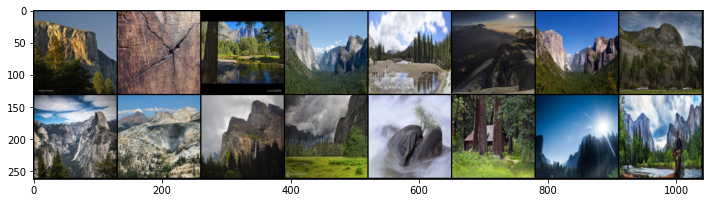

In [6]:
# helper imshow function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    

# get some images from X
dataiter = iter(dataloader_X)
# the "_" is a placeholder for no labels
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12, 8))
imshow(torchvision.utils.make_grid(images))

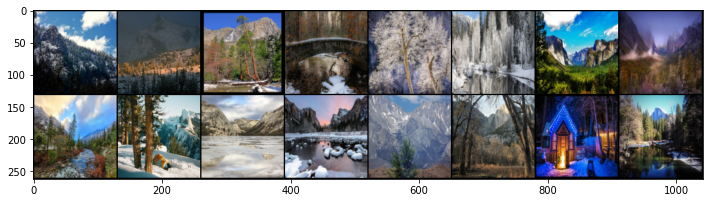

In [7]:
# get some images from Y
dataiter = iter(dataloader_Y)
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12,8))
imshow(torchvision.utils.make_grid(images))

# Pre-processing: Scaling from -1 to 1

In [8]:
img = images[0]

print(img.min())
print(img.max())

tensor(0.)
tensor(1.)


In [0]:
def scale(x, feature_range=(-1, 1)):
  min, max = feature_range
  x = x*(max-min) + min
  return x

In [10]:
scaled_img = scale(images[9])

print('Scaled image : ', scaled_img.min())
print('Scaled image : ', scaled_img.max())

Scaled image :  tensor(-0.9294)
Scaled image :  tensor(0.9529)


# Convolutional Helper Function

In [0]:
import torch.nn as nn
import torch.nn.functional as F

def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
  layers = []
  conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
  layers.append(conv_layer)
  if batch_norm:
    layers.append(nn.BatchNorm2d(out_channels))
  return nn.Sequential(*layers)

# Discriminators

In [0]:
class Discriminator(nn.Module):
  def __init__(self, conv_dim=64):
    super(Discriminator, self).__init__()

    self.conv1 = conv(3, conv_dim, kernel_size=4, batch_norm=False)
    self.conv2 = conv(conv_dim, conv_dim*2, kernel_size=4)
    self.conv3 = conv(conv_dim*2, conv_dim*4, kernel_size=4)
    self.conv4 = conv(conv_dim*4, conv_dim*8, kernel_size=4)
    
    self.conv5 = conv(conv_dim*8, 1, kernel_size=4, stride=1, batch_norm=False)
  
  def forward(self, x):
    out = F.relu(self.conv1(x))
    out = F.relu(self.conv2(out))
    out = F.relu(self.conv3(out))
    out = F.relu(self.conv4(out))

    out = self.conv5(out)
    return out

# Generators

G (x to y) and G(y to x)

Residual class - 

collection of 2 conv layers : 

Generates a new mapping : 

x -> F(x) + x 

In [0]:
class ResidualBlock(nn.Module):
  def __init__(self, conv_dim):
    super(ResidualBlock, self).__init__()

    self.conv1 = conv(conv_dim, conv_dim, kernel_size=3, stride=1)
    self.conv2 = conv(conv_dim, conv_dim, kernel_size=3, stride=1)
  
  def forward(self, x):
    out_1 = F.relu(self.conv1(x))
    out_2 = x + self.conv2(out_1)

    return out_2


# Generator - DeConv Helper Class

In [0]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
  layers = []
  t_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
  layers.append(t_conv_layer)
  if batch_norm:
    layers.append(nn.BatchNorm2d(out_channels))
  
  return nn.Sequential(*layers)

In [0]:
class CycleGenerator(nn.Module):  
  def __init__(self, conv_dim=64, n_res_blocks=6):
    super(CycleGenerator, self).__init__()

    # 1. define the encoder part
    self.conv1 = conv(3, conv_dim, 4)
    self.conv2 = conv(conv_dim, conv_dim*2, 4)
    self.conv3 = conv(conv_dim*2, conv_dim*4, 4)

    res_layers = []
    for layer in range(n_res_blocks):
      res_layers.append(ResidualBlock(conv_dim*4))
    
    self.res_blocks = nn.Sequential(*res_layers)
    
    self.deconv1 = deconv(conv_dim*4, conv_dim*2, 4)
    self.deconv2 = deconv(conv_dim*2, conv_dim, 4)
    self.deconv3 = deconv(conv_dim, 3, 4, batch_norm=False)
  
  def forward(self, x):

    out = F.relu(self.conv1(x))
    out = F.relu(self.conv2(out))
    out = F.relu(self.conv3(out))

    out = self.res_blocks(out)

    out = F.relu(self.deconv1(out))
    out = F.relu(self.deconv2(out))

    out = F.tanh(self.deconv3(out))

    return out



# Create Models

In [0]:
def create_model(g_conv_dim=64, d_conv_dim=64, n_res_blocks=4):
  G_XtoY = CycleGenerator(g_conv_dim, n_res_blocks)
  G_YtoX = CycleGenerator(g_conv_dim, n_res_blocks)

  D_X = Discriminator(conv_dim=d_conv_dim)
  D_Y = Discriminator(conv_dim=d_conv_dim)

  if torch.cuda.is_available():
    G_XtoY.cuda()
    G_YtoX.cuda()

    D_X.cuda()
    D_Y.cuda()
  else:
    print('GPU not available')
  
  return G_XtoY, G_YtoX, D_X, D_Y


In [0]:
G_XtoY, G_YtoX, D_X, D_Y = create_model()

In [0]:
# helper function for printing the model architecture
def print_models(G_XtoY, G_YtoX, D_X, D_Y):
    """Prints model information for the generators and discriminators.
    """
    print("                     G_XtoY                    ")
    print("-----------------------------------------------")
    print(G_XtoY)
    print()

    print("                     G_YtoX                    ")
    print("-----------------------------------------------")
    print(G_YtoX)
    print()

    print("                      D_X                      ")
    print("-----------------------------------------------")
    print(D_X)
    print()

    print("                      D_Y                      ")
    print("-----------------------------------------------")
    print(D_Y)
    print()
    

# print all of the models
print_models(G_XtoY, G_YtoX, D_X, D_Y)

# Defining Loss and Optimizer for Cyclic GANs

In [0]:
def real_mse_loss(D_out):
  return torch.mean((D_out-1)**2)

def fake_mse_loss(D_out):
  return torch.mean(D_out**2)

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight):
  reconstr_loss = torch.mean(torch.abs(real_im - reconstructed_im))
  return lambda_weight * reconstr_loss


In [0]:
import torch.optim as optim

lr = 0.0002
beta1 = 0.5
beta2 = 0.999

g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())

g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
d_x_optimizer = optim.Adam(D_X.parameters(), lr, [beta1, beta2])
d_y_optimizer = optim.Adam(D_Y.parameters(), lr, [beta1, beta2])

# Training Cyclic GANs

In [0]:
# helper functions for saving sample data and models

# import data loading libraries
import os
import pdb
import pickle
import argparse
import imageio

import warnings
warnings.filterwarnings("ignore")

# import torch
import torch


# numpy & scipy imports
import numpy as np
import scipy
import scipy.misc


def checkpoint(iteration, G_XtoY, G_YtoX, D_X, D_Y, checkpoint_dir='checkpoints_cyclegan'):
    """Saves the parameters of both generators G_YtoX, G_XtoY and discriminators D_X, D_Y.
        """
    G_XtoY_path = os.path.join(checkpoint_dir, 'G_XtoY.pkl')
    G_YtoX_path = os.path.join(checkpoint_dir, 'G_YtoX.pkl')
    D_X_path = os.path.join(checkpoint_dir, 'D_X.pkl')
    D_Y_path = os.path.join(checkpoint_dir, 'D_Y.pkl')
    torch.save(G_XtoY.state_dict(), G_XtoY_path)
    torch.save(G_YtoX.state_dict(), G_YtoX_path)
    torch.save(D_X.state_dict(), D_X_path)
    torch.save(D_Y.state_dict(), D_Y_path)


def merge_images(sources, targets, batch_size=16):
    """Creates a grid consisting of pairs of columns, where the first column in
        each pair contains images source images and the second column in each pair
        contains images generated by the CycleGAN from the corresponding images in
        the first column.
        """
    _, _, h, w = sources.shape
    row = int(np.sqrt(batch_size))
    merged = np.zeros([3, row*h, row*w*2])
    for idx, (s, t) in enumerate(zip(sources, targets)):
        i = idx // row
        j = idx % row
        merged[:, i*h:(i+1)*h, (j*2)*h:(j*2+1)*h] = s
        merged[:, i*h:(i+1)*h, (j*2+1)*h:(j*2+2)*h] = t
    merged = merged.transpose(1, 2, 0)
    return merged
    

def to_data(x):
    """Converts variable to numpy."""
    if torch.cuda.is_available():
        x = x.cpu()
    x = x.data.numpy()
    x = ((x +1)*255 / (2)).astype(np.uint8) # rescale to 0-255
    return x

def save_samples(iteration, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16, sample_dir='samples_cyclegan'):
    """Saves samples from both generators X->Y and Y->X.
        """
    # move input data to correct device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    fake_X = G_YtoX(fixed_Y.to(device))
    fake_Y = G_XtoY(fixed_X.to(device))
    
    X, fake_X = to_data(fixed_X), to_data(fake_X)
    Y, fake_Y = to_data(fixed_Y), to_data(fake_Y)
    
    merged = merge_images(X, fake_Y, batch_size)
    path = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    imageio.imsave(path, merged)
    print('Saved {}'.format(path))
    
    merged = merge_images(Y, fake_X, batch_size)
    path = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    imageio.imsave(path, merged)
    print('Saved {}'.format(path))


In [0]:
# import save code

def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, n_epochs=1000):
  print_every = 10

  # keep track of losses
  losses = []

  test_iter_X = iter(test_dataloader_X)
  test_iter_Y = iter(test_dataloader_Y)

  fixed_X = test_iter_X.next()[0]
  fixed_Y = test_iter_Y.next()[0]
  fixed_X = scale(fixed_X)
  fixed_Y = scale(fixed_Y)

  iter_X = iter(dataloader_X)
  iter_Y = iter(dataloader_Y)
  batches_per_epoch = min(len(iter_X), len(iter_Y))

  for epoch in range(1, n_epochs+1):

    if epoch % batches_per_epoch == 0:
      iter_X = iter(dataloader_X)
      iter_Y = iter(dataloader_Y)

    images_X, _ = iter_X.next()
    images_X = scale(images_X)

    images_Y, _ = iter_Y.next()
    images_Y = scale(images_Y)

    if torch.cuda.is_available():
      images_X, images_Y = images_X.cuda(), images_Y.cuda()
    
    # ============================================
    #            TRAIN THE DISCRIMINATORS
    # ============================================

    # First calculate real and fake loss for D_X

    d_x_optimizer.zero_grad()

    out_x = D_X(images_X)
    D_X_real_loss = real_mse_loss(out_x)

    fake_X = G_YtoX(images_Y)

    out_x = D_X(fake_X)
    D_X_fake_loss = fake_mse_loss(fake_X)

    d_x_loss = D_X_real_loss + D_X_fake_loss
    d_x_loss.backward()
    d_x_optimizer.step()

    
    # Second calculate real and fake loss for D_Y

    d_y_optimizer.zero_grad()

    out_y = D_Y(images_Y)
    D_Y_real_loss = real_mse_loss(out_y)

    fake_Y = G_XtoY(images_X)

    out_y = D_Y(fake_Y)
    D_Y_fake_loss = fake_mse_loss(fake_Y)

    d_y_loss = D_Y_real_loss + D_Y_fake_loss
    d_y_loss.backward()
    d_y_optimizer.step()

    # =========================================
    #            TRAIN THE GENERATORS
    # =========================================
    g_optimizer.zero_grad()

    ## Genrate fake X and reconstructed Y images

    # 1. real_loss for g_x
    fake_X = G_YtoX(images_Y)

    out_x = D_X(fake_X)
    g_YtoX_loss = real_mse_loss(out_x)

    reconstructed_Y = G_XtoY(fake_X)
    reconstructed_y_loss = cycle_consistency_loss(images_Y, reconstructed_Y, lambda_weight=10)

    ## Generate fake Y and reconstructed X images
    fake_Y = G_XtoY(images_X)

    out_y = D_Y(fake_Y)
    g_XtoY_loss = real_mse_loss(out_y)

    # create reconstructed x and reconstructed_x consistency loss
    reconstructed_X = G_YtoX(fake_Y)
    reconstructed_x_loss = cycle_consistency_loss(images_X, reconstructed_X, lambda_weight=10)

    # Adding up all the Generator losses
    g_total_loss =  g_YtoX_loss + g_XtoY_loss + reconstructed_x_loss +reconstructed_y_loss
    g_total_loss.backward()
    g_optimizer.step()

    # Print the log info
    if epoch % print_every == 0:
      # append real and fake discriminator losses and the generator loss
      losses.append((d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
      print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
              epoch, n_epochs, d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))   
      
  
    sample_every=100
    # Save the generated samples
    if epoch % sample_every == 0:
      G_YtoX.eval() # set generators to eval mode for sample generation
      G_XtoY.eval()
      save_samples(epoch, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16)
      G_YtoX.train()
      G_XtoY.train()

  
  return losses
    
  

    
  


# Final Ouput

In [46]:
n_epochs = 500 # keep this small when testing if a model first works

losses = training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, n_epochs=n_epochs)

Epoch [   10/  500] | d_X_loss: 0.3018 | d_Y_loss: 0.2647 | g_total_loss: 2.3924
Epoch [   20/  500] | d_X_loss: 0.2710 | d_Y_loss: 0.2759 | g_total_loss: 2.1937
Epoch [   30/  500] | d_X_loss: 0.3109 | d_Y_loss: 0.2943 | g_total_loss: 2.5246
Epoch [   40/  500] | d_X_loss: 0.3009 | d_Y_loss: 0.3002 | g_total_loss: 2.5904
Epoch [   50/  500] | d_X_loss: 0.3027 | d_Y_loss: 0.3125 | g_total_loss: 2.5268
Epoch [   60/  500] | d_X_loss: 0.3033 | d_Y_loss: 0.3281 | g_total_loss: 2.1806
Epoch [   70/  500] | d_X_loss: 0.2317 | d_Y_loss: 0.2682 | g_total_loss: 2.4192
Epoch [   80/  500] | d_X_loss: 0.2511 | d_Y_loss: 0.3284 | g_total_loss: 2.6260
Epoch [   90/  500] | d_X_loss: 0.2744 | d_Y_loss: 0.3062 | g_total_loss: 2.2647


Epoch [  100/  500] | d_X_loss: 0.3349 | d_Y_loss: 0.3354 | g_total_loss: 2.9460


Saved samples_cyclegan/sample-000100-X-Y.png
Saved samples_cyclegan/sample-000100-Y-X.png
Epoch [  110/  500] | d_X_loss: 0.3208 | d_Y_loss: 0.3493 | g_total_loss: 4.0333
Epoch [  120/  500] | d_X_loss: 0.3426 | d_Y_loss: 0.3065 | g_total_loss: 3.9282
Epoch [  130/  500] | d_X_loss: 0.2752 | d_Y_loss: 0.2989 | g_total_loss: 2.9701
Epoch [  140/  500] | d_X_loss: 0.3444 | d_Y_loss: 0.2940 | g_total_loss: 3.2184
Epoch [  150/  500] | d_X_loss: 0.3544 | d_Y_loss: 0.3091 | g_total_loss: 4.1459
Epoch [  160/  500] | d_X_loss: 0.2743 | d_Y_loss: 0.2882 | g_total_loss: 3.0701
Epoch [  170/  500] | d_X_loss: 0.2707 | d_Y_loss: 0.3043 | g_total_loss: 2.6728
Epoch [  180/  500] | d_X_loss: 0.2923 | d_Y_loss: 0.2864 | g_total_loss: 2.6437
Epoch [  190/  500] | d_X_loss: 0.3099 | d_Y_loss: 0.3036 | g_total_loss: 2.9580


Epoch [  200/  500] | d_X_loss: 0.2699 | d_Y_loss: 0.3084 | g_total_loss: 3.1508


Saved samples_cyclegan/sample-000200-X-Y.png
Saved samples_cyclegan/sample-000200-Y-X.png
Epoch [  210/  500] | d_X_loss: 0.2507 | d_Y_loss: 0.2837 | g_total_loss: 2.4362
Epoch [  220/  500] | d_X_loss: 0.3141 | d_Y_loss: 0.2820 | g_total_loss: 3.1243
Epoch [  230/  500] | d_X_loss: 0.2914 | d_Y_loss: 0.2786 | g_total_loss: 2.7658
Epoch [  240/  500] | d_X_loss: 0.2772 | d_Y_loss: 0.2903 | g_total_loss: 2.6758
Epoch [  250/  500] | d_X_loss: 0.2867 | d_Y_loss: 0.2636 | g_total_loss: 2.5170
Epoch [  260/  500] | d_X_loss: 0.2925 | d_Y_loss: 0.2941 | g_total_loss: 2.4979
Epoch [  270/  500] | d_X_loss: 0.3215 | d_Y_loss: 0.3415 | g_total_loss: 2.5112
Epoch [  280/  500] | d_X_loss: 0.3211 | d_Y_loss: 0.2960 | g_total_loss: 2.4573
Epoch [  290/  500] | d_X_loss: 0.2570 | d_Y_loss: 0.2749 | g_total_loss: 2.7173


Epoch [  300/  500] | d_X_loss: 0.2892 | d_Y_loss: 0.2933 | g_total_loss: 2.4741


Saved samples_cyclegan/sample-000300-X-Y.png
Saved samples_cyclegan/sample-000300-Y-X.png
Epoch [  310/  500] | d_X_loss: 0.3077 | d_Y_loss: 0.2925 | g_total_loss: 2.6719
Epoch [  320/  500] | d_X_loss: 0.2997 | d_Y_loss: 0.2876 | g_total_loss: 2.4068
Epoch [  330/  500] | d_X_loss: 0.2817 | d_Y_loss: 0.2861 | g_total_loss: 2.2111
Epoch [  340/  500] | d_X_loss: 0.2610 | d_Y_loss: 0.2845 | g_total_loss: 2.3257
Epoch [  350/  500] | d_X_loss: 0.2799 | d_Y_loss: 0.2769 | g_total_loss: 2.3849
Epoch [  360/  500] | d_X_loss: 0.3097 | d_Y_loss: 0.2725 | g_total_loss: 2.5117
Epoch [  370/  500] | d_X_loss: 0.3221 | d_Y_loss: 0.2773 | g_total_loss: 2.1959
Epoch [  380/  500] | d_X_loss: 0.2895 | d_Y_loss: 0.2940 | g_total_loss: 2.4202
Epoch [  390/  500] | d_X_loss: 0.3160 | d_Y_loss: 0.2891 | g_total_loss: 2.2445


Epoch [  400/  500] | d_X_loss: 0.3239 | d_Y_loss: 0.3084 | g_total_loss: 2.0030


Saved samples_cyclegan/sample-000400-X-Y.png
Saved samples_cyclegan/sample-000400-Y-X.png
Epoch [  410/  500] | d_X_loss: 0.2982 | d_Y_loss: 0.3096 | g_total_loss: 2.3767
Epoch [  420/  500] | d_X_loss: 0.2870 | d_Y_loss: 0.2653 | g_total_loss: 2.4104
Epoch [  430/  500] | d_X_loss: 0.2757 | d_Y_loss: 0.2646 | g_total_loss: 2.2037
Epoch [  440/  500] | d_X_loss: 0.3032 | d_Y_loss: 0.2750 | g_total_loss: 2.1843
Epoch [  450/  500] | d_X_loss: 0.2887 | d_Y_loss: 0.2854 | g_total_loss: 2.4308
Epoch [  460/  500] | d_X_loss: 0.3049 | d_Y_loss: 0.3233 | g_total_loss: 2.2073
Epoch [  470/  500] | d_X_loss: 0.3078 | d_Y_loss: 0.3000 | g_total_loss: 2.3228
Epoch [  480/  500] | d_X_loss: 0.2888 | d_Y_loss: 0.2889 | g_total_loss: 2.0347
Epoch [  490/  500] | d_X_loss: 0.2989 | d_Y_loss: 0.3011 | g_total_loss: 2.2018


Epoch [  500/  500] | d_X_loss: 0.3021 | d_Y_loss: 0.3054 | g_total_loss: 2.4846


Saved samples_cyclegan/sample-000500-X-Y.png
Saved samples_cyclegan/sample-000500-Y-X.png


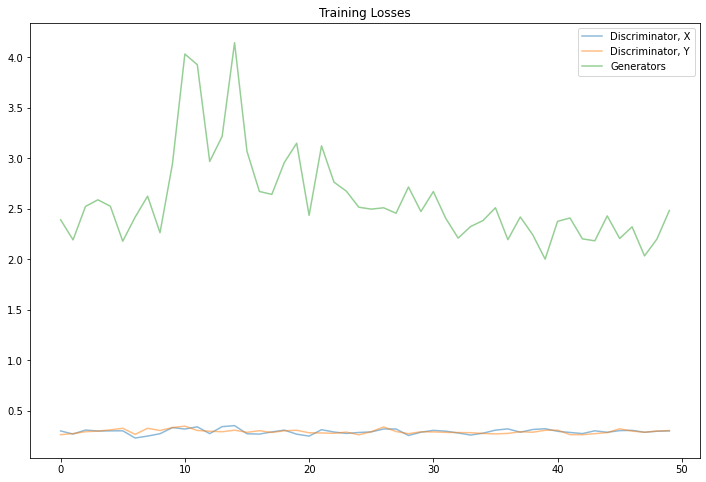

In [47]:
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator, X', alpha=0.5)
plt.plot(losses.T[1], label='Discriminator, Y', alpha=0.5)
plt.plot(losses.T[2], label='Generators', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [0]:
import matplotlib.image as mpimg

# helper visualization code
def view_samples(iteration, sample_dir='samples_cyclegan'):
    
    # samples are named by iteration
    path_XtoY = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    path_YtoX = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    
    # read in those samples
    try: 
        x2y = mpimg.imread(path_XtoY)
        y2x = mpimg.imread(path_YtoX)
    except:
        print('Invalid number of iterations.')
    
    fig, (ax1, ax2) = plt.subplots(figsize=(18,20), nrows=2, ncols=1, sharey=True, sharex=True)
    ax1.imshow(x2y)
    ax1.set_title('X to Y')
    ax2.imshow(y2x)
    ax2.set_title('Y to X')


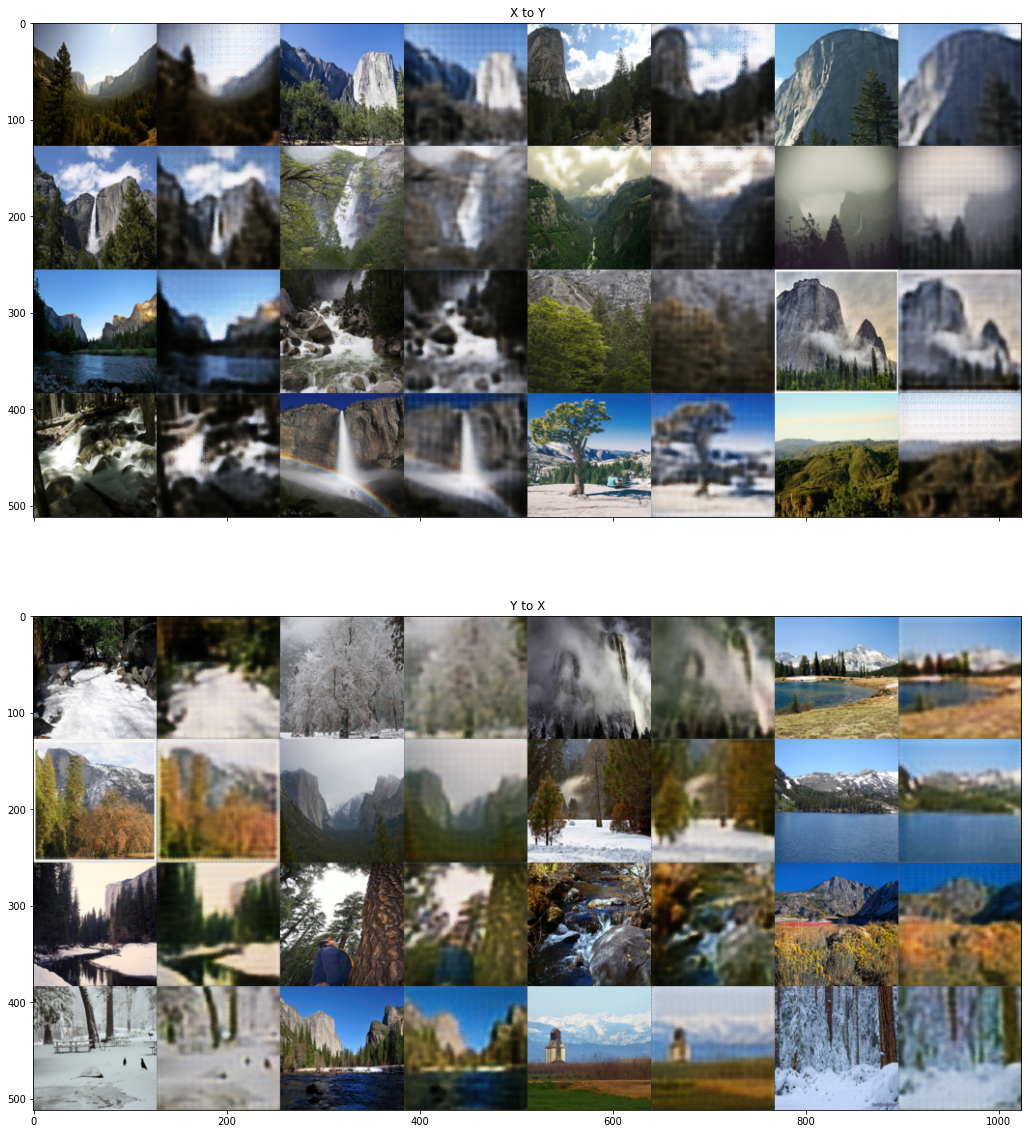

In [50]:
# view samples at iteration 100
view_samples(500, 'samples_cyclegan')